# Generate logo plots 

This notebook generates logo plots for the escape maps for each antibody. 

Import python modules: 

In [1]:
import os

import altair as alt
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import dmslogo
from dmslogo.colorschemes import ValueToColorMap

Set filtering parameters: 

In [2]:
#here are filtering parameters
sums_threshold = 0.99 #will include top X% of summed escape sites
max_threshold = 0.99 #will include top X% of max escape sites

escape_std_cutoff = 1 #only antibody escape mutants below this escape_std will be included
func_times_seen_cutoff = 2 #how many times a unique barcoded mutation was observed in functional selections
antibody_times_seen = 2 #how many times a unique barcoded mutation was observed in antibody escape

Load data: 

In [3]:
ab_dfs = {'10-1074': './results/antibody_escape/averages/10-1074_mut_effect.csv',
         '3BNC117': './results/antibody_escape/averages/3BNC117_mut_effect.csv'}
abs = ['10-1074', '3BNC117']
func_scores = pd.read_csv('./results/func_effects/averages/TZM-bl_entry_func_effects.csv')
site_numbering_map = pd.read_csv('./data/site_numbering_map.csv')
site_numbering_map['site']=site_numbering_map['reference_site']

Process each antibody dataframe:

In [4]:
processed_dfs = {}
for ab in ab_dfs:
    ab_df = pd.read_csv(ab_dfs[ab])
    # Merge mAb escape file with functional_scores
    processed_df = ab_df.merge(func_scores, on=['site','wildtype','mutant'],how='left',suffixes=['_ab','_func_effects'])
    processed_df = processed_df.merge(site_numbering_map[['site', 'sequential_site']], on=['site'])
    # Filter the dataframes based on filtering parameters
    processed_df = (processed_df
                    .query('mutant!="*"')
                    .query('mutant!="-"')
                    .query('effect>-4')
                    .query('times_seen_func_effects>=@func_times_seen_cutoff')
                    .query('times_seen_ab>=@antibody_times_seen')
                   )
    processed_dfs[ab] = processed_df

Get sites to show: 

In [5]:
all_sites_to_show = {}
    
for ab in processed_dfs:
    ab_sites_to_show = []
    processed_df = processed_dfs[ab]
    # Get sites with max score over some percentile threshold
    sums_max = processed_df.groupby('site')['escape_median'].max()
    quantile_max = sums_max.quantile(sums_threshold)
    sites_max_score = sums_max[sums_max > quantile_max].index.tolist()
    for site in sites_max_score:
        if site not in ab_sites_to_show:
            ab_sites_to_show.append(site)
    
    # Get sites with sum score over percentile threshold
    sums_total = processed_df.groupby('site')['escape_median'].sum()
    quantile_total = sums_total.quantile(max_threshold)
    sites_agg_sum = sums_total[sums_total > quantile_total].index.tolist()
    for site in sites_agg_sum:
        if site not in ab_sites_to_show:
            ab_sites_to_show.append(site)
    all_sites_to_show[ab] = ab_sites_to_show
for ab in all_sites_to_show: 
    print(sorted(all_sites_to_show[ab]))
# Curated list of sites that includes sites closeby, and other strain escape sites: 
all_sites_to_show = {
    '10-1074': ['140', '141', '151', '299', '324', '325', '326', '327', '328', '329', '330', '332', '333', '334', '415'],
    '3BNC117': ['128', '164', '168', '186', '198', '231', '234', '235', '236', '277', '279', '280', '281', '290', 
                '304', '308', '318', '339', '340', '341', '413', '440', '441', '456', '460', '461', '462', '463', '464', '465', '471'],
}
for ab in all_sites_to_show: 
    print(sorted(all_sites_to_show[ab]))

['141', '143', '144', '325', '327', '328', '330', '332', '334', '387', '452', '480', '571']
['128', '168', '186', '236', '281', '290', '304', '308', '318', '368', '440', '462', '464', '479', '784']
['140', '141', '143', '144', '151', '299', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '415']
['128', '164', '168', '186', '198', '231', '234', '235', '236', '277', '279', '280', '281', '290', '304', '308', '318', '339', '340', '341', '413', '440', '441', '456', '460', '461', '462', '463', '464', '471']


Make the logo plots: 

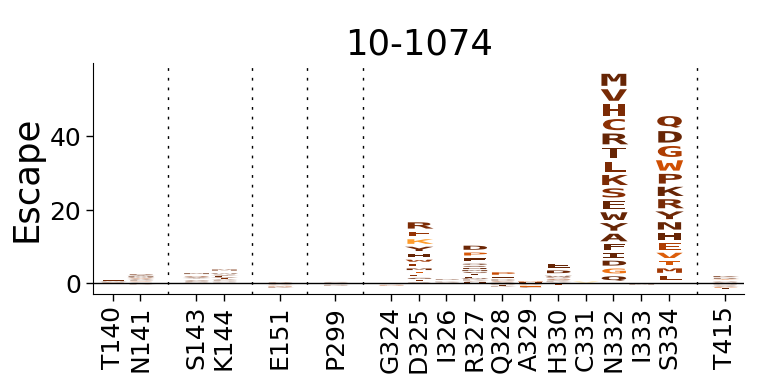

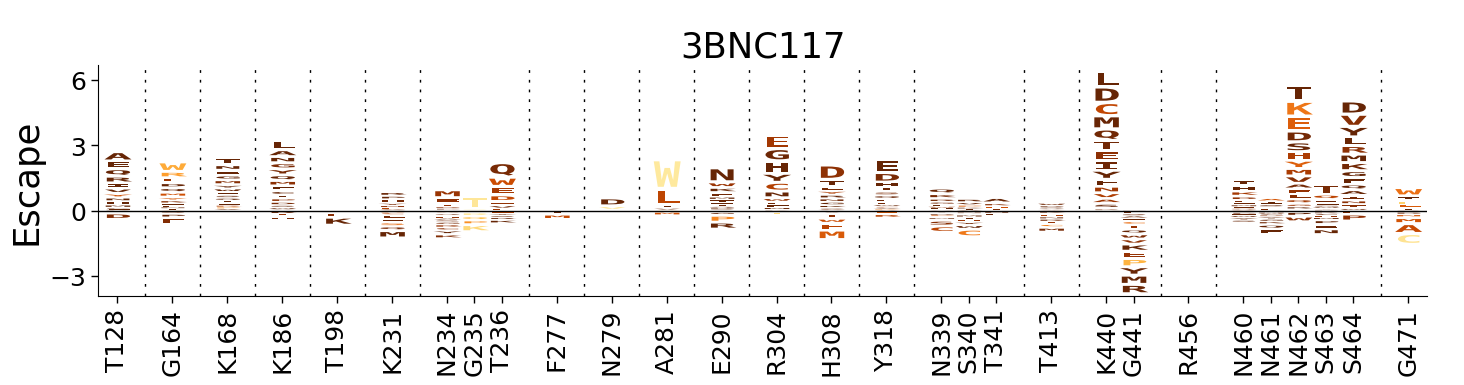

In [6]:
# Make smaller color map, from here: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
arr = np.linspace(0, 50, 100).reshape((10, 10))
cmap = plt.get_cmap('YlOrBr')
new_cmap = truncate_colormap(cmap, .2, 1)

# Make the figures for each antibody
for ab in processed_dfs:
    processed_df = processed_dfs[ab]
    processed_df = processed_df.assign(label=lambda x: x['wildtype'] + x['site'])
    processed_df['show_site'] = processed_df['site'].isin(all_sites_to_show[ab])
    processed_df['clip'] = np.clip(processed_df['effect'], None, 0)
    min_prop = processed_df['effect'].min()
    max_prop = processed_df['clip'].max()
    map1 = ValueToColorMap(minvalue=min_prop, maxvalue=max_prop, cmap=new_cmap)
    processed_df['color'] = processed_df['clip'].map(map1.val_to_color)
    if ab!='':
        x_ticks = 'label'
    else: 
        processed_df['blanks'] = ''
        x_ticks = 'blanks'
    fig, ax = dmslogo.draw_logo(
        data=processed_df.query('show_site'),
        x_col='sequential_site',
        xtick_col=x_ticks,
        letter_col='mutant',
        letter_height_col='escape_median',
        ylabel='Escape',
        xlabel='',
        color_col='color',
        title=ab,
        axisfontscale=1.5,
    )
    fig.savefig(f'./results/logoplots/{ab}_logoplot.svg', bbox_inches='tight',format='svg')

Make a figure for the color scale: 

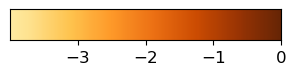

In [7]:
fig, _ = map1.scale_bar(orientation='horizontal')
fig.savefig(f'./results/logoplots/scalebar_figure.svg', bbox_inches='tight',format='svg')